# Welcome 👋

Hi, I'm **Ashiq Nazir Bhat**,  
**Research Scholar** and **AP Contractual - 1**,  
Previously **JRF at Thapar Institute of Engineering & Technology**.  

### 🌟 About Me  
- 📊 Passionate about Data Science, Data Security and AI.
- 🛠️ Skilled in Python, R, SQL, Non SQL and Secure Data Analysis.
- 🌱 Constantly learning and sharing knowledge!

### 🌟 Credentials  
- **#UGCNET23 Qualified**  
- **#GATE21 & #GATE22 Qualified**  

This notebook showcases insights and analysis on **HMM Speech Modelling and Training**. Let's dive in!  

---

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### 📲 Connect With Me  

<a href="https://github.com/ashiqnazirbhat" target="_blank" style="margin-right:5px;">
    <i class="fab fa-github" style="font-size:20px; color:black;"></i>
</a>
<a href="https://www.linkedin.com/in/ashiqnazir/" target="_blank" style="margin-right:5px;">
    <i class="fab fa-linkedin" style="font-size:20px; color:#0077B5;"></i>
</a>
<a href="mailto:bhatashiq4gmail.com" target="_blank" style="margin-right:5px;">
    <i class="fas fa-envelope" style="font-size:20px; color:#D44638;"></i>
</a>
<a href="https://ashiqnazirbhat.github.io/" target="_blank" style="margin-right:5px;">
    <i class="fas fa-globe" style="font-size:20px; color:#4CAF50;"></i>
</a>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-wav-audio-files/Beethoven_Diabelli_Variation_No._13.wav
/kaggle/input/sample-wav-audio-files/Divisive_rhythm_in_4-4_time.wav
/kaggle/input/sample-wav-audio-files/BAK.wav
/kaggle/input/sample-wav-audio-files/Circle_of_fifths_chord_progression_-_minor.wav
/kaggle/input/sample-wav-audio-files/Mozart_from_Piano_Sonata_K310_first_movement.wav
/kaggle/input/spech-model-dataset/audio/orange/orange08.wav
/kaggle/input/spech-model-dataset/audio/orange/orange11.wav
/kaggle/input/spech-model-dataset/audio/orange/orange02.wav
/kaggle/input/spech-model-dataset/audio/orange/orange01.wav
/kaggle/input/spech-model-dataset/audio/orange/orange03.wav
/kaggle/input/spech-model-dataset/audio/orange/orange10.wav
/kaggle/input/spech-model-dataset/audio/orange/orange15.wav
/kaggle/input/spech-model-dataset/audio/orange/orange07.wav
/kaggle/input/spech-model-dataset/audio/orange/orange12.wav
/kaggle/input/spech-model-dataset/audio/orange/orange13.wav
/kaggle/input/spech-model-dataset/audio

 ## 🛠️ **Project Overview** 

This notebook demonstrates the development of a **speech recognition system** using a combination of **Hidden Markov Models (HMMs)** and **Logistic Regression** for word-level classification. The workflow includes:

1. **Data Augmentation**: Enhancing the dataset with pitch shifts, time stretching, and speed adjustments.
2. **Feature Extraction**: Extracting **MFCC** and **delta features** to capture spectral and temporal dynamics.
3. **Class-Specific HMMs**: Training separate HMMs for each word to model.
4. **Word-Level Classification**: Using log-likelihood scores from the HMMs as features to train a LR.
5. **Evaluation**: Assessing the system's performance reports and confusion matrices and addressing class imbalance using data augmentation and class weighting.

This notebook combines traditional HMM-based sequence modeling with modern machine learning techniques to achieve robust speech recognition.

Please **Upvote Dateset and Notebook**, to keep motivating... 

## 🛠️ **Import Libraries**  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

## 🛠️ Get Input
#### Reads a .wav audio file using wavfile.read(). 

* **sampling_freq:** The audio sampling rate.
* **audio.shape:** (mono: (n_samples,), stereo: (n_samples, 2)).
* **audio.dtype:** (int16, float32).
* **Duration:** audio.shape[0] / sampling_freq (seconds).

In [3]:
sampling_freq, audio = wavfile.read('/kaggle/input/sample-wav-audio-files/BAK.wav')
print( '\nShape:', audio.shape)
print ('Datatype:', audio.dtype)
print ('Duration:', round(audio.shape[0] / float(sampling_freq), 3), 'seconds')


Shape: (367538, 2)
Datatype: int16
Duration: 8.334 seconds


<ipython-input-3-894b411bc508>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_freq, audio = wavfile.read('/kaggle/input/sample-wav-audio-files/BAK.wav')


## 🛠️ Visualise audio

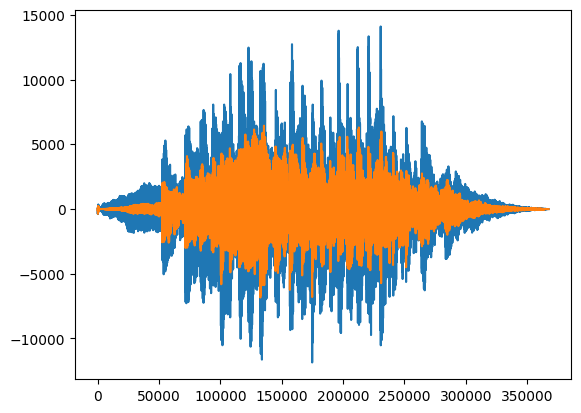

In [4]:
#Plot the complete audio 
plt.plot(audio)

##### Each point represents the amplitude of the signal at a given sample index.

## 🛠️ Channel Division 
##### Stereo Channels: If the signal is stereo, separate and compare the left and right channels.

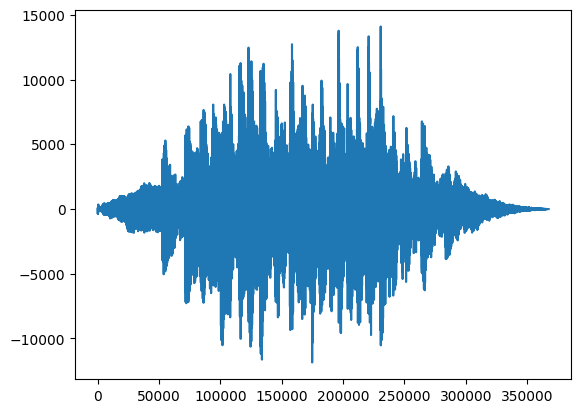

In [5]:
#Plot only left Channel
plt.plot(audio[:, 0], label='Left Channel')

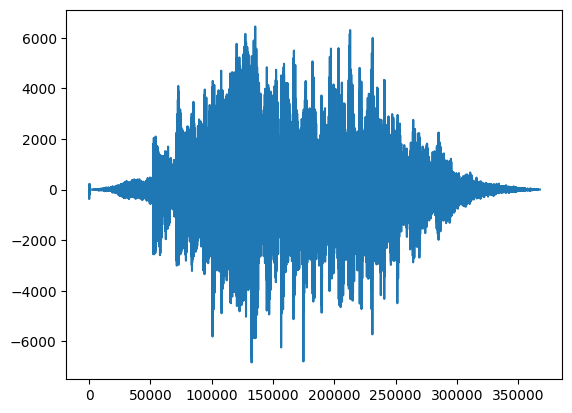

In [6]:
#Plot only right Channel
plt.plot(audio[:, 1], label='Right Channel')

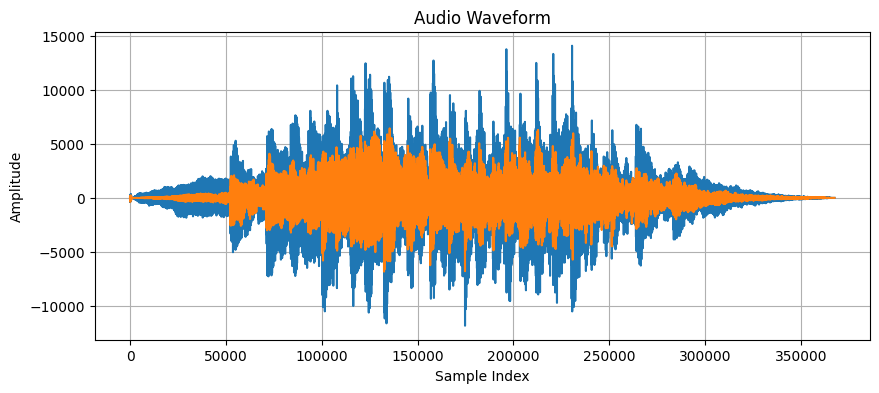

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


##### Consistent loudness normalization across samples. Reducing variations in amplitude that could affect model performance or audio comparison.

## 🛠️ RMS/Volume Normalization: 

##### Calculate the RMS to analyze the perceived loudness and ensure uniform volume across audio signals.

These lines perform **audio normalization** and scaling:

1. **Normalization**: The audio signal is scaled to a range between `-1` and `1` by dividing by the maximum possible value or the maximum absolute value of the signal.
2. **Root Mean Square (RMS) Scaling**: The RMS of the signal is calculated to represent its energy, and the signal is scaled to a target RMS value (e.g., 0.1) to ensure consistent loudness across all audio samples.
3. **Truncation**: Optionally limits the audio to the first 30 samples, likely for testing or computational efficiency.

In [8]:
#audio=audio/2.**15
#audio=audio/np.max(np.abs(audio))
#audio=audio[:30]

#rms = np.sqrt(np.mean(audio**2))
#target_rms = 0.1


#scaling_factor = target_rms / rms
#audio = audio * scaling_factor

### **Positive Effects**:

1. **Consistency Across Samples**:
2. **Improved Generalization**:
3. **Numerical Stability**:
4. **Reduced Noise Sensitivity**:

### **Potential Risks**:
1. **Loss of Information**:
2. **Over-normalization**:

### **Overall Impact**:
- **Normalization** and **RMS scaling** generally improve the model's robustness and performance, especially for audio classification tasks.
- **Truncation**, however, should be used carefully to avoid losing important temporal information, as it could negatively affect the model's ability to learn key patterns.

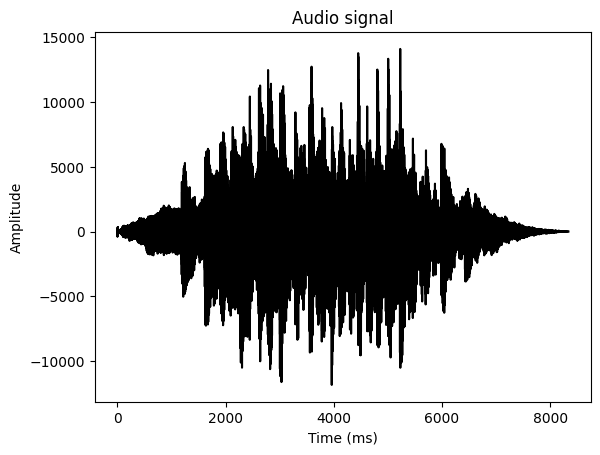

In [9]:
x_values = np.arange(0, len(audio), 1) / float(sampling_freq)
#Multiplying by 1000 converts seconds to milliseconds.
x_values *= 1000
plt.plot(x_values, audio, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio signal')
plt.show()

**Duration:** 8 seconds **Amplitude:** The y-axis ranges -15,000 to 15,000, reflecting the dynamic range of the signal's amplitude, which indicates the intensity or loudness. **Energy Distribution:** The signal's energy appears concentrated between 2000 ms and 6000 ms, suggesting that this part of the audio is louder or contains more activity. At the start (0–2000 ms) and end (6000–8000 ms), the signal tapers off, indicating quieter sections or fades.

## 🛠️ Frequency Analysis: 

To analyze the frequency components of the signal (e.g., low, mid, or high frequencies).

In [10]:
transformed_signal = np.fft.fft(audio)

## 🛠️ What to Look For:
**Peak frequencies:** Peaks in the frequency spectrum indicate dominant frequencies.
**Noise:** Broad, non-peaked regions may indicate noise in the signal.
**Cutoff Frequencies:** Analyze if the signal is band-limited. 

In [11]:
#Calculate Half Length as Fourier Transform of a real-valued signal is symmetric
half_length = np.ceil((len(audio) + 1) / 2.0)
half_length=int(half_length)

#Extracts the magnitude of the first half of the FFT
transformed_signal = abs(transformed_signal[0:half_length])


#Square the Magnitude:
#Squares the magnitude to calculate the power spectrum (energy at each frequency).
#The power spectrum is proportional to the square of the amplitude of the frequency components.
transformed_signal **= 2

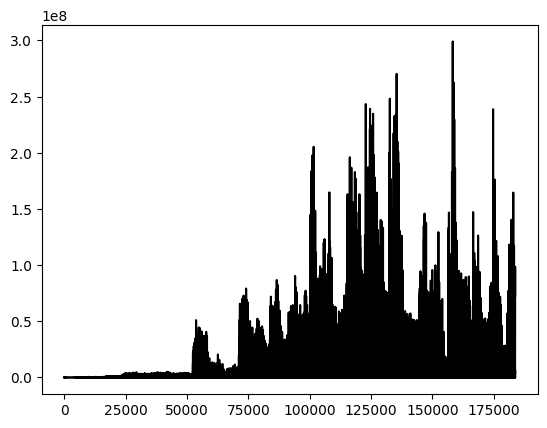

In [12]:
plt.plot(transformed_signal, color='black')

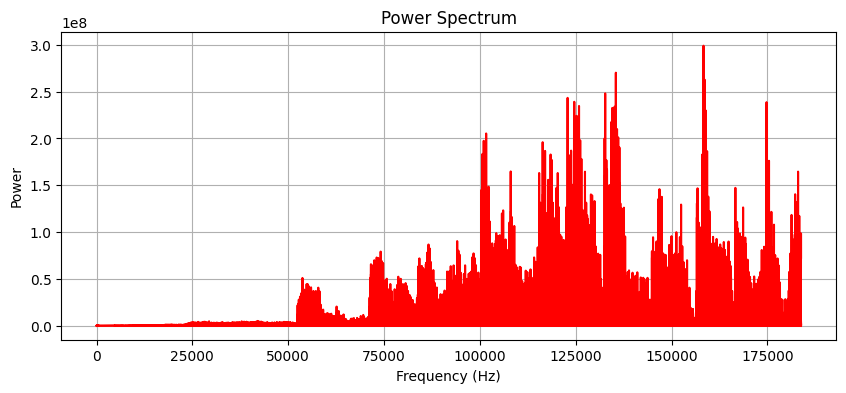

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(transformed_signal, color='red')
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

* **Dominant Frequencies:** Peaks in the spectrum (e.g., near 5,000 Hz and 15,000 Hz) indicate the primary frequency components of the audio signal.

* **Energy Distribution:** Most energy is concentrated in the 0–20,000 Hz range, consistent with human-hearable frequencies.

* **Noise:** The spectrum's broad base suggests some background noise or wide-frequency energy components.

In [14]:
audio

array([[ 9, 27],
       [ 5, 13],
       [-6, -2],
       ...,
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]], dtype=int16)

In [15]:
freqs = np.fft.fftfreq(len(audio), d=1/sampling_freq)[:half_length]

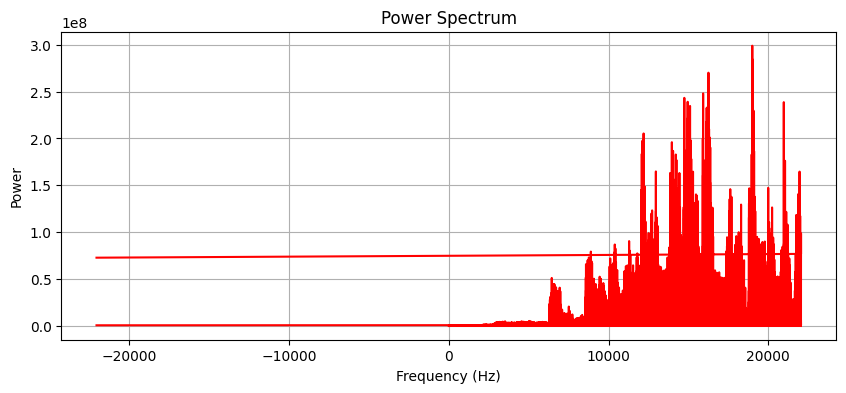

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(freqs, transformed_signal, color='red')
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

## 🛠️ Power Representation:

#### Squaring the FFT values calculates the power spectrum, which represents the energy at each frequency. 

**Frequency Range:** The x-axis extends to 200,000 Hz.

**Energy Peaks:** Clear peaks are visible in the 100,000–175,000 Hz range, indicating high-energy components at these frequencies. These may arise from:

* High-frequency noise or interference.
* Ultrasonic signal components, if this is not a standard audio signal.

**Overall Energy Distribution:**

The power decreases significantly at lower frequencies compared to higher frequencies, which is unusual for most audio signals where lower frequencies often dominate. This might suggest:

* Non-audible high-frequency components.
* High-frequency noise.


## 🛠️ Import Libraries  

In [17]:
import numpy as np
from librosa.feature import mfcc
import librosa

**Librosa** library extract **MFCC (Mel Frequency Cepstral Coefficients)** features from an audio file. MFCCs are commonly used in audio and speech processing to represent the short-term power spectrum of sound on a mel scale. 

- **Number of windows**: Refers to the total number of time frames.
- **Length of each feature**: Indicates the number of MFCC coefficients computed for each time frame, representing the spectral characteristics of the sound.


The **Mel scale** is a perceptual scale of pitches that aligns with how humans perceive sound. It transforms frequencies from the linear Hertz (Hz) scale into a scale that reflects human auditory perception.

**Application**:
   - Widely used in speech and audio processing.
   - **Mel-Frequency Cepstral Coefficients (MFCCs)** are computed by applying the Mel scale to the power spectrum, emphasizing perceptually important frequency bands.


In [18]:
audio,sampling_rate = librosa.load("/kaggle/input/sample-wav-audio-files/BAK.wav")
mfcc_features = mfcc(y=audio,sr=sampling_rate)
print("Number of windows =", mfcc_features.shape[0])
print('Length of each feature =', mfcc_features.shape[1])

Number of windows = 20
Length of each feature = 359


## 🛠️ Get Labels

Iterates through subfolders in the directory and extract file names as labels. 

* lists all subfolders or files in the directory.
* combines the base directory with the folder name to get the full path.
* extracts the folder name after the last * `/`, treating it as a label.

In [19]:
import os
for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
  subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
  label = subfolder[subfolder.rfind('/') + 1:]
  print(label)

orange
lime
pineapple
apple
kiwi
peach
banana


## 🛠️ Install HMM Library

#### [Explore Here](https://pypi.org/project/hmmlearn/#:~:text=hmmlearn%20is%20a%20set%20of,is%20under%20limited%2Dmaintenance%20mode.)

In [20]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


##  🛠️ Import HMM

In [21]:
from scipy.io import wavfile
from hmmlearn import hmm

A **Hidden Markov Model (HMM)** is a statistical model used to represent systems that are **stochastic** (having a random probability distribution) and **time-dependent**, where the underlying states are hidden (unobservable) but can be inferred through observable outputs. It consists of:

1. **States (S))**: Represent the hidden process.  
2. **Observations (O)**: Outputs generated by the hidden states.  
3. **Transition Probabilities (A)**: Probabilities of moving between states over time.  
4. **Emission Probabilities (B)**: Probabilities of an observation being generated from a state.  
5. **Initial State Probabilities ($\pi$ )**: Probabilities of starting in each state.  
6. **State Space (S)**: The set of all possible hidden states.  
7. **Observation Space (O)**: The set of all possible observations.

HMMs are widely used in applications like speech recognition, bioinformatics, and sequence prediction, where temporal or sequential data plays a key role.

### For More Info

* https://www.analyticsvidhya.com/blog/2023/11/hidden-markov-models/?utm_source=Backlink&utm_medium=SEO
* https://medium.com/analytics-vidhya/baum-welch-algorithm-for-training-a-hidden-markov-model-part-2-of-the-hmm-series-d0e393b4fb86
* https://medium.com/analytics-vidhya/viterbi-algorithm-for-prediction-with-hmm-part-3-of-the-hmm-series-6466ce2f5dc6

In [22]:
class HMMTrainer(object):
   def __init__(self, model_name='GaussianHMM', n_components=7):
     self.model_name = model_name
     self.n_components = n_components

     self.models = []
     if self.model_name == 'GaussianHMM':
        self.model=hmm.GaussianHMM(n_components=4)
     else:
        print("Please choose GaussianHMM")
   def train(self, X):
       self.models.append(self.model.fit(X))
   def get_score(self, input_data):
       return self.model.score(input_data)

 ## 🛠️ Model Design 
 
 **Hidden Markov Models (HMMs)**, specifically **Gaussian HMMs** are suitable for modeling continuous data.

#### Key Components:

   - number of hidden states (`n_components`).
   - Initializes a `GaussianHMM` model (from the `hmmlearn` library).

#### Scoring:
   - Computes the **log-likelihood** score of the input data (`input_data`) based on the trained HMM.

In [23]:
import os
import librosa
import numpy as np
from librosa.feature import mfcc

hmm_models = []

for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    
    # Get the name of the subfolder
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    print(subfolder)
    if not os.path.isdir(subfolder):
        continue
      
    # Extract the label
    label = subfolder[subfolder.rfind('/') + 1:]
    
    # Initialize variables
    X = np.array([])
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
        
        # Read the input file
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        
        # Extract MFCC features
        mfcc_features = mfcc(y=audio, sr=sampling_freq)
        
        # Append to the variable X
        if len(X) == 0:
            X = mfcc_features[:, :15]
        else:
            X = np.append(X, mfcc_features[:, :15], axis=0)
        
        print('X.shape =', X.shape)
    
    # Train HMM
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    
    # Append HMM and label to models
    hmm_models.append((hmm_trainer, label))
    
    # Reset the trainer
    hmm_trainer = None

/kaggle/input/spech-model-dataset/audio/orange
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
/kaggle/input/spech-model-dataset/audio/lime
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
/kaggle/input/spech-model-dataset/audio/pineapple
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
/kaggle/input/spech-model-data


## 🛠️Model Use Flow Explanation:
1. **Subfolder Processing**: Each subfolder corresponds to a label.
2. **Feature Extraction**: MFCC features are extracted for all `.wav` files in the subfolder.
3. **HMM Training**: Features are used to train an HMM for the label.
4. **Model Storage**: Trained HMM and its label are saved for future use.

##  🛠️ MFCC Feature Analysis 

The variable **`X`** contains the concatenated **MFCC features** extracted from all `.wav` files in a subfolder. Each row represents the MFCC coefficients (up to 15, as specified) for a time frame, and the entire matrix represents the audio's spectral features for that subfolder. It is used as input for training the HMM.

In [24]:
#MFCC features
X

array([[-310.31516   , -239.39232   , -222.04097   , ..., -283.99384   ,
        -308.0273    , -340.11975   ],
       [ 210.89006   ,  248.39653   ,  247.94693   , ...,  233.35127   ,
         224.59543   ,  206.28949   ],
       [ -38.006752  ,  -66.30003   ,  -90.32977   , ...,  -58.620728  ,
         -42.265938  ,  -28.42572   ],
       ...,
       [  -2.292787  ,   -3.4187686 ,    0.47804636, ...,   -7.036072  ,
          -7.9631634 ,   -9.418622  ],
       [   7.848727  ,    5.019228  ,    0.64853656, ...,  -10.897797  ,
         -14.071741  ,  -12.037746  ],
       [  -1.3645455 ,  -12.657408  ,  -19.413216  , ...,  -11.027496  ,
         -13.686246  ,   -9.3804035 ]], dtype=float32)

### Insights:
- **Shape**: How many time frames and coefficients are present.
- **Statistics**: Variation and range of MFCC values, which can indicate spectral diversity.
- **Visualization**: Temporal and spectral patterns in the audio data.
- **Correlation**: Relationships between MFCC coefficients to identify redundancies or dependencies.

In [25]:
print("Shape of X:", X.shape)

Shape of X: (280, 15)


##  📈 Output Stats 

In [26]:
# Calculate statistics
mean_values = np.mean(X, axis=0)
median_values = np.median(X, axis=0)
std_dev_values = np.std(X, axis=0)
range_values = np.ptp(X, axis=0)

# Combine into a DataFrame
stats_df = pd.DataFrame({
    "Mean": mean_values,
    "Median": median_values,
    "Standard Deviation": std_dev_values,
    "Range (Max-Min)": range_values
}, index=[f"MFCC_{i+1}" for i in range(X.shape[1])])

#Show dataframe
stats_df

,Mean,Median,Standard Deviation,Range (Max-Min)
MFCC_1,-19.868387,-7.301952,95.204651,723.186218
MFCC_2,-17.820221,-12.180065,88.657532,619.223572
MFCC_3,-17.784342,-12.440913,88.851891,594.312744
MFCC_4,-17.694849,-12.872902,90.337273,607.671753
MFCC_5,-17.977358,-12.573469,93.069946,649.150024
MFCC_6,-18.442413,-12.899935,96.833702,674.186035
MFCC_7,-17.973732,-11.165137,97.897774,677.498901
MFCC_8,-17.513025,-11.480856,96.726280,660.946411
MFCC_9,-17.869711,-11.051455,95.807281,653.313293
MFCC_10,-18.538319,-11.285243,95.568970,651.190430


In [27]:
print("Contains NaN values:", np.isnan(X).any())
print("Contains infinite values:", np.isinf(X).any())

Contains NaN values: False
Contains infinite values: False


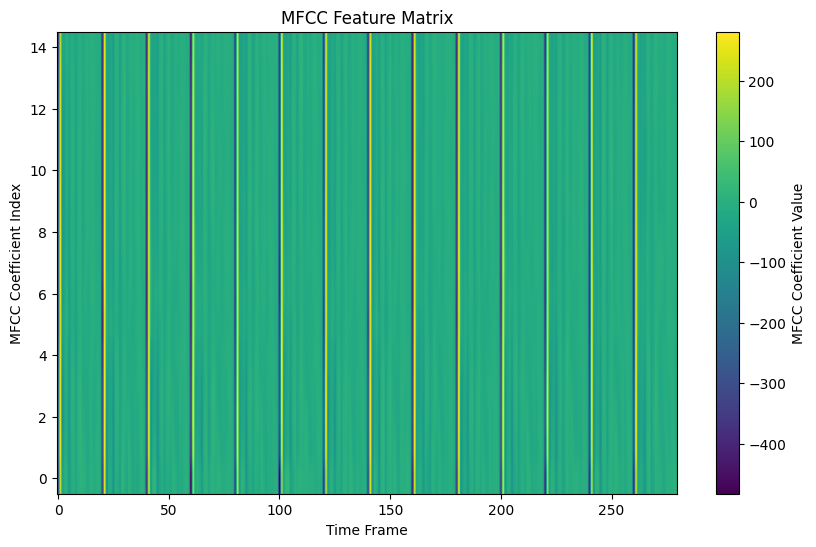

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(X.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='MFCC Coefficient Value')
plt.xlabel('Time Frame')
plt.ylabel('MFCC Coefficient Index')
plt.title('MFCC Feature Matrix')
plt.show()

## 📈 Output Analysis 

The visualization shows the spectral characteristics of an audio signal over time:

1. **X-Axis**: Represents the time frames of the audio, capturing short-term segments of the signal.
2. **Y-Axis**: Represents the MFCC coefficients (features) for each time frame, with lower indices capturing broad spectral energy and higher indices capturing finer details.
3. **Color Intensity**: Indicates the magnitude of the MFCC coefficients, with yellow representing higher values and purple lower values.

The alternating vertical patterns suggest periodic changes in the spectral energy, possibly due to repeating or structured audio patterns like speech or music.

The **first 13 MFCCs (Mel-Frequency Cepstral Coefficients)** are extracted from an audio signal to represent its spectral characteristics. 

| **MFCC Index** | **Interpretation** |
|--------------|-----------------|
| **MFCC 1**  | Represents the overall energy of the signal (similar to loudness). |
| **MFCC 2**  | Captures broad spectral shape, related to the formant structure. |
| **MFCC 3**  | Represents finer details of the first formant (F1). |
| **MFCC 4**  | Captures information about the second formant (F2). |
| **MFCC 5**  | Describes additional spectral shape variations. |
| **MFCC 6**  | Captures higher frequency spectral characteristics. |
| **MFCC 7**  | Contains mid-range frequency variations. |
| **MFCC 8**  | Represents slightly higher frequency spectral shape. |
| **MFCC 9**  | Captures subtle frequency variations important for distinguishing phonemes. |
| **MFCC 10** | Represents rapid spectral transitions. |
| **MFCC 11** | Captures fine-grained variations in spectral features. |
| **MFCC 12** | Sensitive to high-frequency spectral changes. |
| **MFCC 13** | Represents the finest details of the speech signal. |

### **Note**
- **MFCC 1** is different from the others because it represents **energy** rather than spectral shape.
- **MFCCs 2-13** primarily describe the **shape of the spectral envelope**, which helps in differentiating phonemes in speech recognition and identifying different sounds.

### Why Consider Only few Out of 39 Features in MFCC?

MFCCs are commonly used in speech and sound processing. Typically, **39 features** are extracted per frame, but many applications reduce this to **only 13–15 features**. 

### **1. Reducing Dimensionality While Retaining Key Information**
   - MFCCs capture spectral envelope information, but higher-order coefficients contribute **less to speech recognition**.
   - Higher-order coefficients mostly capture noise and fine details that may not be useful for classification.


### **3. Standard Acoustic Feature Set**
   - In most speech and sound recognition tasks, the **standard feature set** consists of:
     - **13 static MFCCs** (cepstral coefficients)
     - **Δ (delta) MFCCs** (1st derivatives)
     - **ΔΔ (delta-delta) MFCCs** (2nd derivatives)
   - This results in a **39-dimensional feature vector** (**13 static + 13 Δ + 13 ΔΔ**).
   - Reducing from **39 to 15** features significantly **lowers computational load**.
   - Many classifiers (e.g., HMM, GMM, or DNN) perform well with just **12–15 MFCCs**.

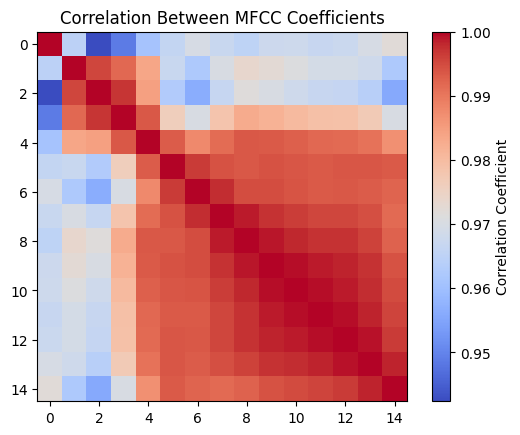

In [29]:
correlation_matrix = np.corrcoef(X.T)


# Plot the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Between MFCC Coefficients')
plt.show()

##  📈 Heatmap Analysis 

Displays the relationships between different MFCC coefficients:

1. **Diagonal Line**: The strong red diagonal (value = 1.0) indicates perfect self-correlation.
2. **High Correlation**: Many off-diagonal coefficients show strong correlations (red regions), suggesting redundancy or strong relationships between certain MFCC features.
3. **Low/Negative Correlation**: Blue areas indicate weak or negative correlations, suggesting complementary features useful for distinguishing patterns in the audio.

It helps identify which features are highly interdependent and which provide unique information, useful for dimensionality reduction or feature selection.

In [30]:
hmm_models

[(<__main__.HMMTrainer at 0x78ff84e62500>, 'orange'),
 (<__main__.HMMTrainer at 0x78ff79528eb0>, 'lime'),
 (<__main__.HMMTrainer at 0x78ff7952b820>, 'pineapple'),
 (<__main__.HMMTrainer at 0x78ff79bb1570>, 'apple'),
 (<__main__.HMMTrainer at 0x78ff79bb21a0>, 'kiwi'),
 (<__main__.HMMTrainer at 0x78ff79bb2a70>, 'peach'),
 (<__main__.HMMTrainer at 0x78ff79f2e7a0>, 'banana')]

In [31]:
len(hmm_models)

7

## 📈 Load new data for Testing

List of **file paths** to specific `.wav` audio files from different subfolders (representing labels) in a dataset. 

In [32]:
input_files = [
'/kaggle/input/spech-model-dataset/audio/pineapple/pineapple15.wav',
'/kaggle/input/spech-model-dataset/audio/orange/orange15.wav',
'/kaggle/input/spech-model-dataset/audio/apple/apple15.wav',
'/kaggle/input/spech-model-dataset/audio/kiwi/kiwi15.wav'
]

## 📈 **Model Testing**  

1. **Iterate Through Models**
2. **Load Input Audio**
3. **Extract Features**
4. **Calculate Scores**
5. **Find Best Match**
6. **Output Results**

In [33]:
scores = []

# Extract MFCC features with 15 coefficients, consistent with training data
audio, sampling_freq = librosa.load(input_files[1])
mfcc_features = mfcc(y=audio, sr=sampling_freq)[:, :15]

# Iterate through trained HMM models
for item in hmm_models:
    hmm_model, label = item
    
    # Get the log-likelihood score for the input features
    score = hmm_model.get_score(mfcc_features)
    scores.append(score)

# Find the model with the highest score
index = np.array(scores).argmax()

# Print the true label and predicted label
print("\nTrue:", input_files[1])
print("Predicted:", hmm_models[index][1])



True: /kaggle/input/spech-model-dataset/audio/orange/orange15.wav
Predicted: orange


In [34]:
hmm_models

[(<__main__.HMMTrainer at 0x78ff84e62500>, 'orange'),
 (<__main__.HMMTrainer at 0x78ff79528eb0>, 'lime'),
 (<__main__.HMMTrainer at 0x78ff7952b820>, 'pineapple'),
 (<__main__.HMMTrainer at 0x78ff79bb1570>, 'apple'),
 (<__main__.HMMTrainer at 0x78ff79bb21a0>, 'kiwi'),
 (<__main__.HMMTrainer at 0x78ff79bb2a70>, 'peach'),
 (<__main__.HMMTrainer at 0x78ff79f2e7a0>, 'banana')]

In [35]:
scores

[-1187.5701003390666,
 -1325.901441129756,
 -1253.0021359660143,
 -1303.8144265297105,
 -1545.252836929304,
 -1424.4897298682004,
 -1283.600033318803]

## 📈 **Score Analysis** 

* Each score represents the log-likelihood of the input MFCC features matching a particular model (label).
* The higher (less negative) the score, the better the fit between the features and the corresponding model

## **Alternative to Hidden Markov Models (HMM)**


* **Gaussian Mixture Models**
* **Dynamic Time Warping**
* **Recurrent Neural Networks**
* **Convolutional Neural Networks for Sequential Data**
* **Transformers**
* **Kalman Filters**
* **WaveNet**
* **Autoregressive Models (ARIMA)**
* **Support Vector Machines for Sequential Kernels**


### Application area: 
- For **traditional tasks**: HMM, GMM, and Kalman Filters are reliable.
- For **modern approaches**: RNNs, Transformers, and CNNs offer greater flexibility and accuracy but require more data and computation.
- **Emerging trends**: Models like WaveNet and Transformers are setting new standards in speech and audio processing.


##  🛠️ Single Model Solution

In [36]:
import os
import numpy as np
import librosa
from sklearn.linear_model import LogisticRegression
from librosa.feature import mfcc
from hmmlearn import hmm

In [37]:
# Initialize variables
X_combined = np.array([])  # Combined MFCC features for all words
y_labels = []              # Labels for word-level classification
word_labels = []           # List of unique word labels

In [38]:
# Iterate through subfolders (each word label)
for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    label = subfolder[subfolder.rfind('/') + 1:]  # Extract label
    word_labels.append(label)  # Store the label
    
    # Extract MFCC features for each audio file
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        mfcc_features = mfcc(y=audio, sr=sampling_freq)[:, :15]
        
        # Append MFCC features to combined data
        if len(X_combined) == 0:
            X_combined = mfcc_features
        else:
            X_combined = np.append(X_combined, mfcc_features, axis=0)
        
        y_labels.append(label)  # Append label for each audio file

In [39]:
# Train a shared HMM for all words
shared_hmm = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=100)
shared_hmm.fit(X_combined)

GaussianHMM(n_components=10, n_iter=100)

In [40]:
# Compute log-likelihood scores for each word
log_likelihoods = []

for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    label = subfolder[subfolder.rfind('/') + 1:]  # Label
    word_lls = []  # Log-likelihoods for this word
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        mfcc_features = mfcc(y=audio, sr=sampling_freq)[:, :15]
        
        # Get log-likelihood for this file
        score = shared_hmm.score(mfcc_features)
        word_lls.append(score)
    
    log_likelihoods.append(word_lls)

In [41]:
# Convert log-likelihoods into feature matrix for classification
X_classifier = np.array([ll for sublist in log_likelihoods for ll in sublist])
y_classifier = np.array(y_labels)

In [42]:
X_classifier.shape

(105,)

In [43]:
y_classifier.shape

(105,)

In [44]:
# Train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_classifier.reshape(-1, 1), y_classifier)

LogisticRegression(max_iter=1000)

In [45]:
# Test the shared HMM and word-level classifier
input_file = '/kaggle/input/spech-model-dataset/audio/orange/orange15.wav'

# Extract MFCC features from the input file
audio, sampling_freq = librosa.load(input_file)
mfcc_features = mfcc(y=audio, sr=sampling_freq)[:, :15]

# Get the log-likelihood score for the input
test_score = shared_hmm.score(mfcc_features)

# Use the classifier to predict the label
predicted_label = classifier.predict([[test_score]])

# Print results
print("Input file:", input_file)
print("Predicted label:", predicted_label[0])

Input file: /kaggle/input/spech-model-dataset/audio/orange/orange15.wav
Predicted label: peach


In [46]:
from sklearn.metrics import classification_report
y_pred = classifier.predict(X_classifier.reshape(-1, 1))
print(classification_report(y_classifier, y_pred))

              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        15
      banana       0.00      0.00      0.00        15
        kiwi       0.00      0.00      0.00        15
        lime       0.00      0.00      0.00        15
      orange       0.00      0.00      0.00        15
       peach       0.14      1.00      0.25        15
   pineapple       0.00      0.00      0.00        15

    accuracy                           0.14       105
   macro avg       0.02      0.14      0.04       105
weighted avg       0.02      0.14      0.04       105



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Performance Failure, Single Model Fails

Let's Try Again

## 🛠️ **Single Model With Extra Features and Improved Parameters**

In [47]:
import os
import librosa
import numpy as np
from librosa.feature import mfcc
from hmmlearn import hmm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [48]:
# Initialize variables
X_combined = np.array([])  # Combined MFCC features for all words
y_labels = []              # Labels for word-level classification
word_labels = []           # List of unique word labels

In [49]:
# Step 1: Prepare Training Data
for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    label = subfolder[subfolder.rfind('/') + 1:]  # Extract label
    word_labels.append(label)  # Store the label
    
    # Extract MFCC features for each audio file
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        
        # Extract MFCC and delta features
        mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
        delta_features = librosa.feature.delta(mfcc_features)
        combined_features = np.vstack([mfcc_features, delta_features]).T  # Combine features
        
        # Append to the combined data
        if len(X_combined) == 0:
            X_combined = combined_features
        else:
            X_combined = np.append(X_combined, combined_features, axis=0)
        
        y_labels.append(label)  # Append label for each audio file

In [50]:
# Step 2: Train the Shared HMM
shared_hmm = hmm.GaussianHMM(n_components=15, covariance_type='diag', n_iter=200)
shared_hmm.fit(X_combined)

GaussianHMM(n_components=15, n_iter=200)

In [51]:
# Step 3: Compute Log-Likelihoods for Classifier Training
log_likelihoods = []
for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
        delta_features = librosa.feature.delta(mfcc_features)
        combined_features = np.vstack([mfcc_features, delta_features]).T
        
        # Compute log-likelihood score
        score = shared_hmm.score(combined_features)
        log_likelihoods.append(score)

In [52]:
# Prepare classifier training data
X_classifier = np.array(log_likelihoods).reshape(-1, 1)
y_classifier = np.array(y_labels)

In [53]:
# Step 4: Train the Word-Level Classifier
classifier = LogisticRegression(C=0.1, max_iter=1000)
classifier.fit(X_classifier, y_classifier)

LogisticRegression(C=0.1, max_iter=1000)

In [54]:
# Step 5: Test the Model
input_file = '/kaggle/input/spech-model-dataset/audio/orange/orange15.wav'

# Extract MFCC and delta features from the test file
audio, sampling_freq = librosa.load(input_file)
mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
delta_features = librosa.feature.delta(mfcc_features)
combined_features = np.vstack([mfcc_features, delta_features]).T

# Get the log-likelihood score
test_score = shared_hmm.score(combined_features)

# Predict the label using the classifier
predicted_label = classifier.predict([[test_score]])

# Print results
print("Input file:", input_file)
print("Predicted label:", predicted_label[0])

Input file: /kaggle/input/spech-model-dataset/audio/orange/orange15.wav
Predicted label: orange



Classification Report:

              precision    recall  f1-score   support

       apple       0.55      0.73      0.63        15
      banana       0.35      0.40      0.38        15
        kiwi       0.25      0.20      0.22        15
        lime       0.44      0.27      0.33        15
      orange       0.79      0.73      0.76        15
       peach       0.75      0.80      0.77        15
   pineapple       0.82      0.93      0.87        15

    accuracy                           0.58       105
   macro avg       0.57      0.58      0.57       105
weighted avg       0.57      0.58      0.57       105



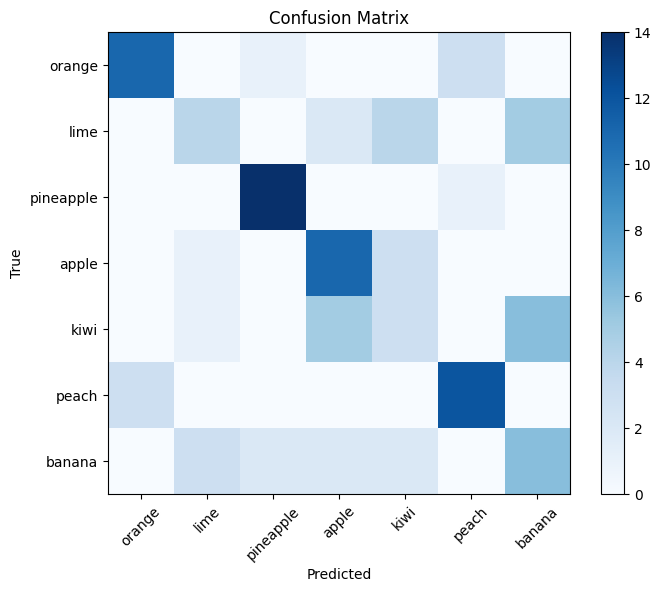

In [55]:
# Step 6: Evaluate the Classifier
y_pred = classifier.predict(X_classifier)
print("\nClassification Report:\n")
print(classification_report(y_classifier, y_pred))

# Optional: Plot the Confusion Matrix
cm = confusion_matrix(y_classifier, y_pred, labels=word_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(word_labels)), word_labels, rotation=45)
plt.yticks(np.arange(len(word_labels)), word_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Performace Improved Yet for some classes showing low performnace 


* Feature Enhancement: Added delta-MFCC features for capturing temporal dynamics.
* HMM Parameter Tuning: n_components and n_iter.
* Regularized Classifier:Used LR with L2 regularization (C=0.1).
* Robust Testing: MFCC and delta features for the test file.


HMM often struggles to classify different sounds using a **single model** due to several key limitations:

### 1. **HMM Assumes Stationarity and Markovian Properties**
   - HMM assumes that the state transitions depend only on the previous state, which is a **first-order Markov assumption**. However, sound signals often have **long-term dependencies** and require context beyond the previous state.

### 2. **Single Model Lacks Differentiation Between Classes**
   - A single HMM is typically trained to **model the probability distribution of one type of sound** (e.g., a word, phoneme, or specific sound event).

### 3. **HMM is Generative, Not Discriminative**
   - HMM is a **generative model**, meaning it estimates the **joint probability** of observations and hidden states.
   - Classification tasks are better suited for **discriminative models** like Deep Neural Networks (DNNs).

### 4. **Limited Feature Representation**
   - HMM uses simple **Gaussian Mixture Models (GMMs)** or discrete emission probabilities for feature modeling.
   - This representation is often inadequate for complex sound patterns where deep learning models (e.g., CNNs, BiLSTMs) can extract **better hierarchical features**.

### 5. **Fixed Number of States & Overlapping Sound Variability**
   - HMM requires **predefined states** that represent the sequence of observations. However, sounds are highly variable and can **overlap in feature space**, making it hard for a single HMM to capture **all variations**.

### 6. **Noise and Overlapping Sounds**
   - HMMs assume **clean and structured sequences**, making them **prone to misclassification** in real-world noisy environments.

### 7. **Alternative: Multiple HMMs or Hybrid Models**
   - **Solution 1:** Instead of a single HMM, use **multiple HMMs** (one per class) and classify sounds based on **maximum likelihood**.
   - **Solution 2:** Use **hybrid models** like HMM + DNN (Deep Neural Network) or HMM + CNN (Convolutional Neural Network) to improve feature extraction and classification.


## 🛠️ **Multi Model Solution With LR**

In [56]:
import os
import librosa
import numpy as np
from librosa.feature import mfcc
from hmmlearn import hmm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

In [57]:
# Step 1: Data Augmentation and Feature Extraction
def augment_audio(audio, sampling_freq):
    """Apply basic data augmentation techniques to audio."""
    augmented_data = [
        audio,
        librosa.effects.pitch_shift(audio, sr=sampling_freq, n_steps=2),  # Pitch shift
        librosa.effects.time_stretch(audio, rate=0.8),  # Time-stretch (slower)
        librosa.effects.time_stretch(audio, rate=1.2)   # Speed up
    ]
    return augmented_data

# Initialize variables
X_combined = np.array([])  # Combined MFCC features
y_labels = []              # Labels for each frame
word_labels = []           # Unique word labels

for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    label = subfolder[subfolder.rfind('/') + 1:]
    word_labels.append(label)
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        
        # Apply augmentation and extract features
        for augmented_audio in augment_audio(audio, sampling_freq):
            mfcc_features = mfcc(y=augmented_audio, sr=sampling_freq, n_mfcc=15)
            delta_features = librosa.feature.delta(mfcc_features)
            combined_features = np.vstack([mfcc_features, delta_features]).T
            
            # Append features
            if len(X_combined) == 0:
                X_combined = combined_features
            else:
                X_combined = np.append(X_combined, combined_features, axis=0)
            
            # Append labels for each frame
            y_labels.extend([label] * combined_features.shape[0])

In [58]:
# Step 2: Train Class-Specific HMMs
hmm_models = {}
for label in word_labels:
    label_features = X_combined[np.array(y_labels) == label]
    hmm_model = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=200)
    hmm_model.fit(label_features)
    hmm_models[label] = hmm_model

In [59]:
# Step 3: Compute Log-Likelihood Scores
log_likelihoods = []
true_labels = []

for dirname in os.listdir('/kaggle/input/spech-model-dataset/audio'):
    subfolder = os.path.join('/kaggle/input/spech-model-dataset/audio', dirname)
    if not os.path.isdir(subfolder):
        continue
    
    label = subfolder[subfolder.rfind('/') + 1:]
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
        delta_features = librosa.feature.delta(mfcc_features)
        combined_features = np.vstack([mfcc_features, delta_features]).T
        
        # Compute log-likelihoods for all HMM models
        scores = [hmm_models[l].score(combined_features) for l in word_labels]
        log_likelihoods.append(scores)
        true_labels.append(label)

X_classifier = np.array(log_likelihoods)
y_classifier = np.array(true_labels)

In [60]:
# Step 4: Train a Logistic Regression Classifier
scaler = StandardScaler()
X_classifier_scaled = scaler.fit_transform(X_classifier)

# Handle imbalanced data with class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_classifier), y=y_classifier)
class_weights = {label: weight for label, weight in zip(np.unique(y_classifier), weights)}

classifier = LogisticRegression(max_iter=1000, class_weight=class_weights)
classifier.fit(X_classifier_scaled, y_classifier)

LogisticRegression(class_weight={'apple': 1.0, 'banana': 1.0, 'kiwi': 1.0,
                                 'lime': 1.0, 'orange': 1.0, 'peach': 1.0,
                                 'pineapple': 1.0},
                   max_iter=1000)


Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
        kiwi       1.00      1.00      1.00        15
        lime       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00        15
       peach       1.00      1.00      1.00        15
   pineapple       1.00      1.00      1.00        15

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



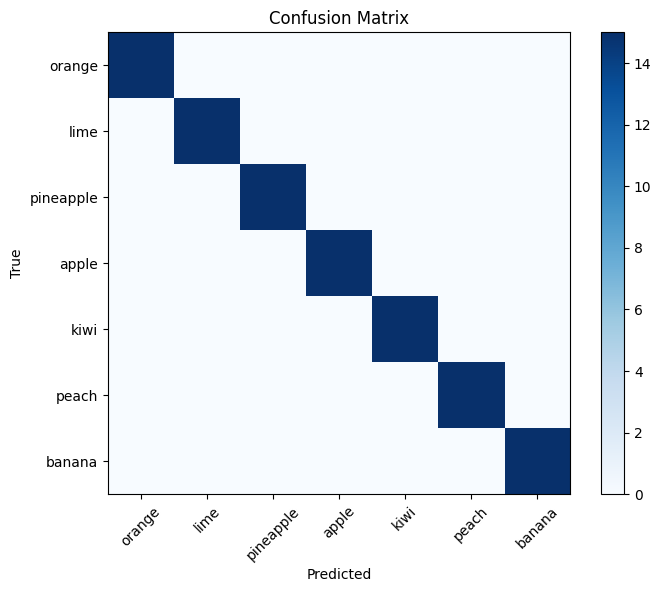

In [61]:
# Step 5: Evaluate the Model
y_pred = classifier.predict(X_classifier_scaled)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_classifier, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_classifier, y_pred, labels=word_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(word_labels)), word_labels, rotation=45)
plt.yticks(np.arange(len(word_labels)), word_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## What’s New:


* Data Augmentation
* Class-Specific HMMs
* Feature Scaling
* Class Weights
* Improved Evaluation



In [62]:
# Step 6: Test on New Data
input_file = '/kaggle/input/spech-model-dataset/audio/orange/orange15.wav'
audio, sampling_freq = librosa.load(input_file)
mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
delta_features = librosa.feature.delta(mfcc_features)
combined_features = np.vstack([mfcc_features, delta_features]).T

test_scores = [hmm_models[l].score(combined_features) for l in word_labels]
test_scores_scaled = scaler.transform([test_scores])

predicted_label = classifier.predict(test_scores_scaled)

print("\nInput file:", input_file)
print("Predicted label:", predicted_label[0])


Input file: /kaggle/input/spech-model-dataset/audio/orange/orange15.wav
Predicted label: orange


## Upvote Notebook and Dataset and Comment